In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft
import glob

def plot_scatter_func(x, y, label, title, xlab, ylab, x1 = None, x2 = None, y1 = None, y2 = None):

    f, ax = plt.subplots(figsize = (20, 10))
    ax.scatter(x, y, label = label)
    ax.set_title(title, fontsize = 30)
    ax.set_xlabel(xlab, fontsize = 30)
    ax.set_ylabel(ylab, fontsize = 30)
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.set_xlim(x1, x2)
    ax.set_ylim(y1, y2)
    ax.legend(loc = 'best', fontsize = 20)
    ax.grid(True)

    return f

def phase_func(Y):
    phases = np.angle(Y) * 180 / np.pi
    
    return phases

def rfft(y): #this function computes the fft of y
    if np.isnan(y).any():
        nan_indices = np.where(np.isin(y))[0]
        print(f"Input data contains NaN values in {nan_indices}.")
        
    if np.isinf(y).any():
        print("Input data contains Inf values.")
        
    N = len(y)
    Y = fft.rfft(y)
    phases = phase_func(Y)
    Y_abs = np.abs(Y)    
    return Y_abs, phases

In [62]:
hour = '15.42'
day = '08082024'

# Method A: Phases of the average of the waveforms

### compute and plot the average of the waveforms

In [63]:
file_pattern = f"../../Waveforms/{day}/{day}_{hour}/{day}_{hour}_wf.csv/{day}_{hour}_wf_*.csv"
file_list = glob.glob(file_pattern)

amplitudes_list_A = []

if not file_list:
    print("No files found for the given pattern.")
else:
    for i, file in enumerate(file_list):
        df = pd.read_csv(file)
        print(df)
        if i == 0:
            times_A = pd.to_numeric(df.iloc[1:, 0], errors = 'coerce').values #The argument errors='coerce' specifies that any non-numeric values encountered during the conversion should be replaced with NaN (Not a Number)
        amplitudes_A = pd.to_numeric(df.iloc[1:, 1], errors='coerce').values
        if np.isnan(amplitudes_A).any():
            nan_indices = np.where(np.isnan(amplitudes_A))[0]
            print(f"Input data contains NaN values in {nan_indices} at {i} file.")
            #amplitudes_A[nan_indices] = 0
 
        amplitudes_list_A.append(amplitudes_A)

all_amplitudes_A = np.stack(amplitudes_list_A, axis = 0)
print(all_amplitudes_A)

              Time    Channel D
0             (us)         (mV)
1       0.00000000  -1.96850400
2       0.00080000  -1.57480300
3       0.00160000  -1.18110200
4       0.00240000  -0.78740150
...            ...          ...
62500  49.99920067   0.00000000
62501  50.00000067   0.39370070
62502  50.00080067  -0.39370070
62503  50.00160067  -1.18110200
62504  50.00240067  -1.18110200

[62505 rows x 2 columns]
              Time    Channel D
0             (us)         (mV)
1       0.00000000   1.57480300
2       0.00080000   0.78740150
3       0.00160000   0.00000000
4       0.00240000   0.00000000
...            ...          ...
62500  49.99920067   1.57480300
62501  50.00000067   0.78740150
62502  50.00080067  -0.39370070
62503  50.00160067  -2.75590500
62504  50.00240067  -4.72440900

[62505 rows x 2 columns]
              Time    Channel D
0             (us)         (mV)
1       0.00000000  -0.39370070
2       0.00080000  -0.39370070
3       0.00160000   0.39370070
4       0.00240000  

In [64]:
avg_wf = np.mean(all_amplitudes_A, axis=0)

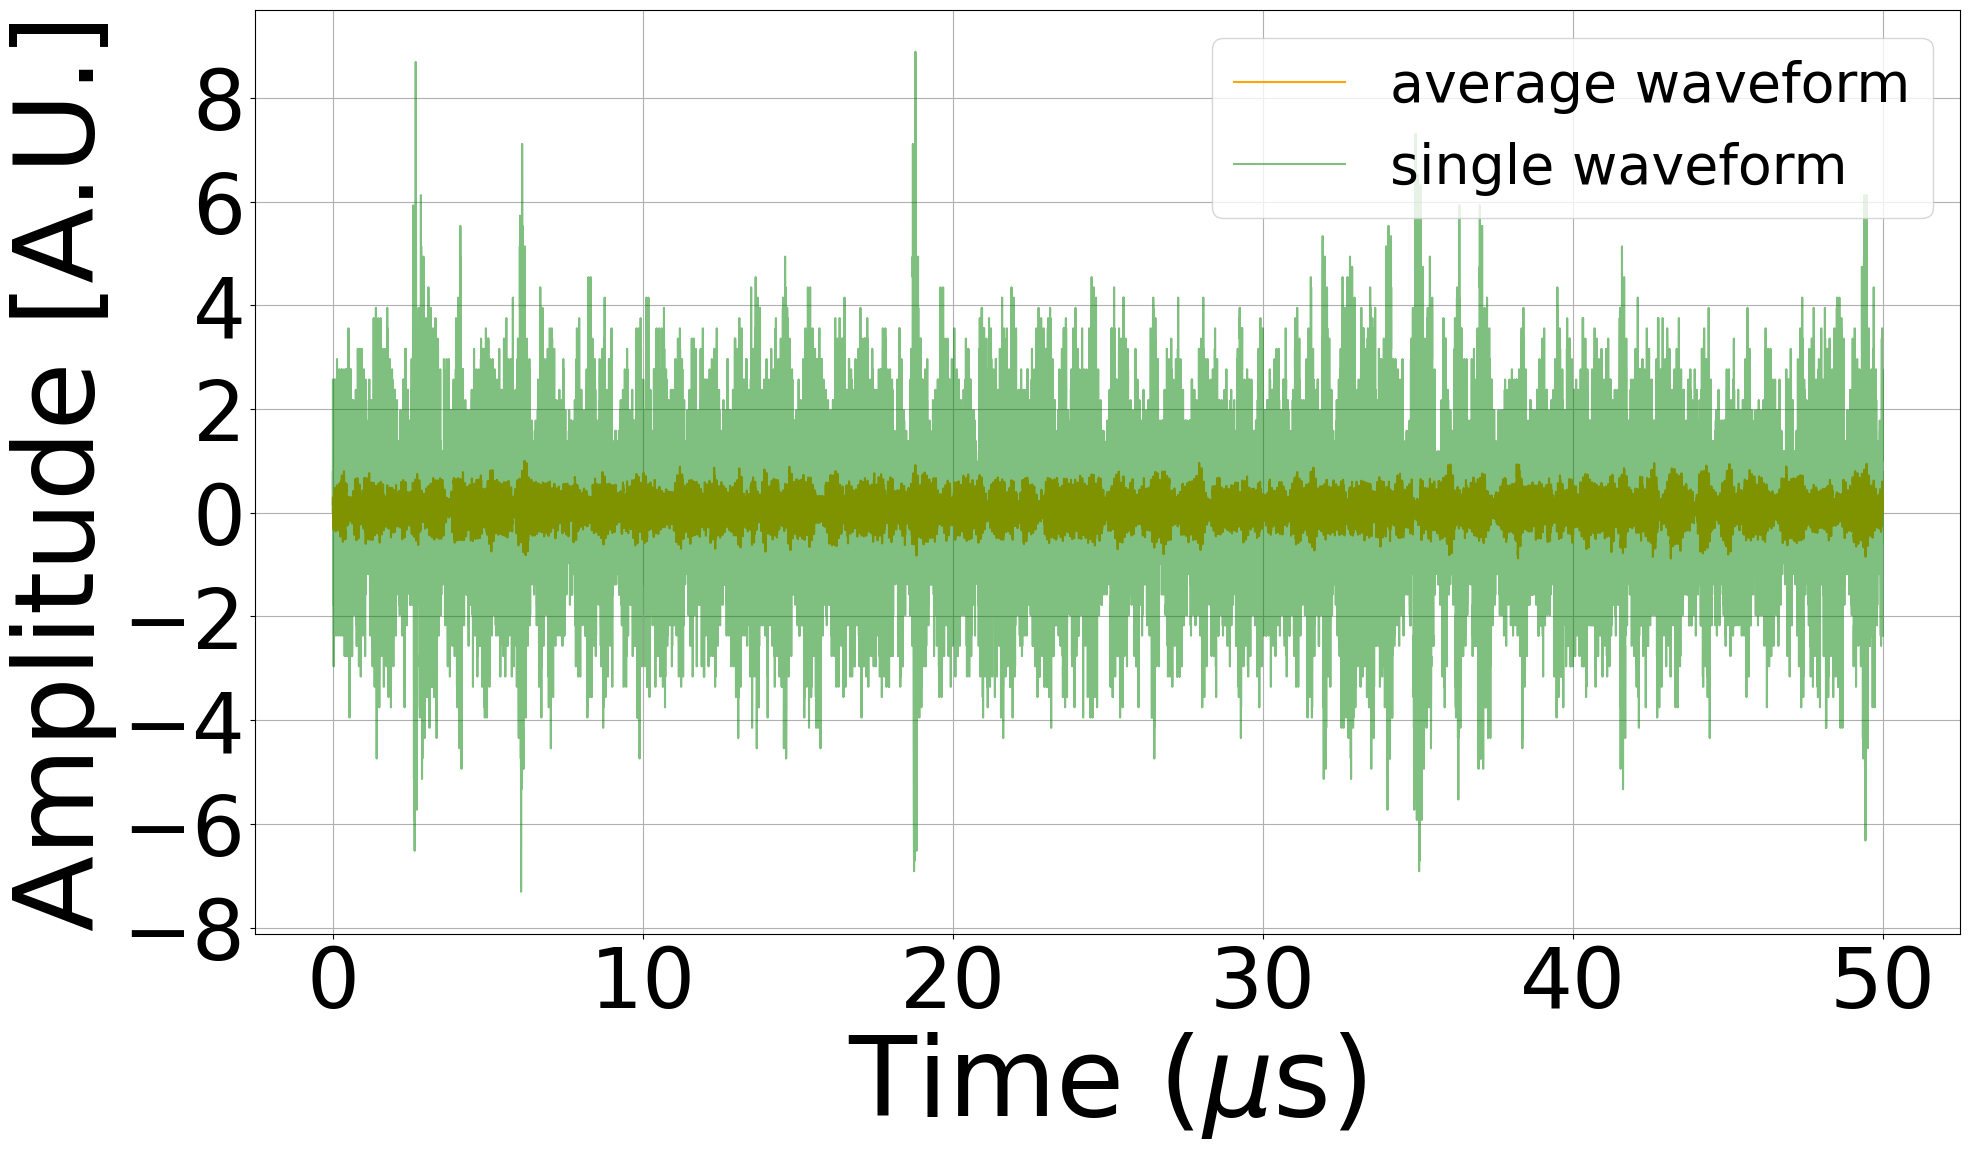

In [78]:
plt.figure(figsize=(22, 12))
plt.plot(times_A, avg_wf/max(avg_wf), color = 'orange', label = 'average waveform')
plt.plot(times_A, all_amplitudes_A[1, :]/max(avg_wf), alpha = 0.5, color = 'green', label = 'single waveform')

plt.title('', fontsize = 80)
plt.xlabel(r'Time ($\mu$s)', fontsize = 80)
plt.xticks(fontsize = 60)
plt.ylabel('Amplitude [A.U.]', fontsize = 80)
plt.yticks(fontsize = 60)
plt.legend(loc = "best",  prop={'size': 40})
plt.grid(True)

plt.savefig("../Results/080824_15.42/A_method/avg_wf_A.png", format = "png", bbox_inches="tight")
plt.savefig("../Results/080824_15.42/A_method/avg_wf_A.pdf", format = "pdf", bbox_inches="tight")

plt.show()

### compute and plot the phases of the average waveform

f_s_A = [1250.01998229]
[8.56275769e+03 5.93445412e+01 4.04247746e+01 ... 7.34907282e+00
 5.85985839e+00 5.72834602e+01]


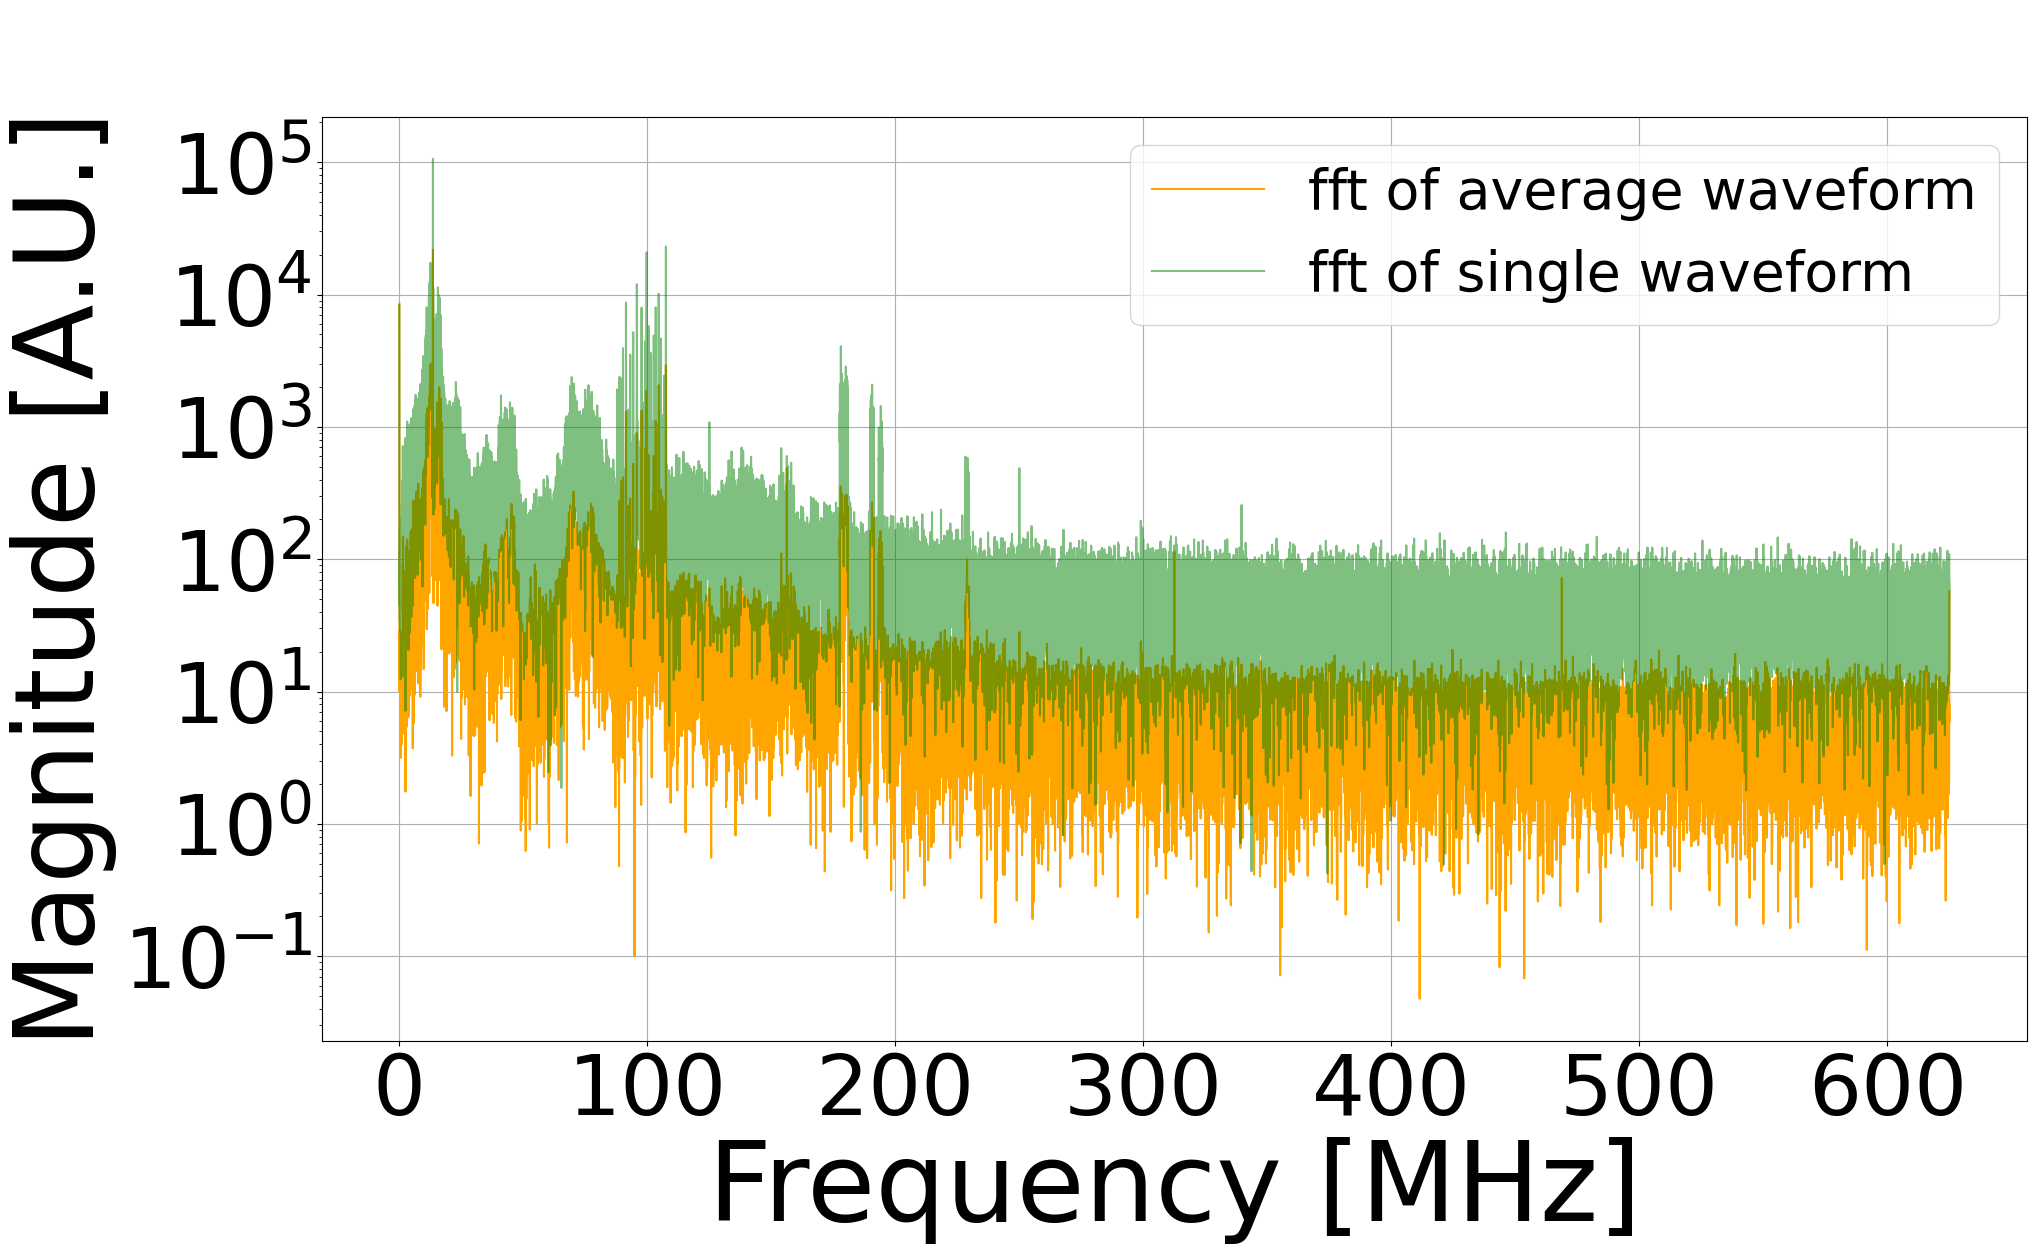

In [66]:
span_A = times_A[-1:]
f_s_A = len(times_A) / span_A
print(f"f_s_A = {f_s_A}")
freqs_A = fft.rfftfreq(len(avg_wf), 1/f_s_A) #window lenght, sample spacing

Y_A, phases_A = rfft(avg_wf)
Y_single_wf_A, phases_single_wf_A = rfft(all_amplitudes_A[1, :])

plt.figure(figsize = (22, 12))
print(Y_A)
plt.plot(freqs_A, Y_A, color = 'orange', label = 'fft of average waveform')
plt.plot(freqs_A, Y_single_wf_A, alpha = 0.5, color = 'green', label = 'fft of single waveform')

plt.title(' ', fontsize = 80)
plt.xlabel('Frequency [MHz]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.ylabel('Magnitude [A.U.]', fontsize = 80)
plt.yticks(fontsize = 60)
plt.grid(True)
plt.semilogy()
plt.legend(fontsize = 40)
plt.show()

In [67]:
Y_A_log = np.log(Y_A)
Y_single_wf_A_log = np.log(Y_single_wf_A)

offset_blue = np.mean(Y_A_log[(freqs_A >= 250) & (freqs_A <= 350)])
offset_orange = np.mean(Y_single_wf_A_log[(freqs_A >= 250) & (freqs_A <= 350)])
print(f"offset blue: {offset_blue} - offset orange: {offset_orange} = {offset_blue - offset_orange}")
diff = offset_blue - offset_orange

offset blue: 1.6910403497866486 - offset orange: 3.763240445529131 = -2.0722000957424824


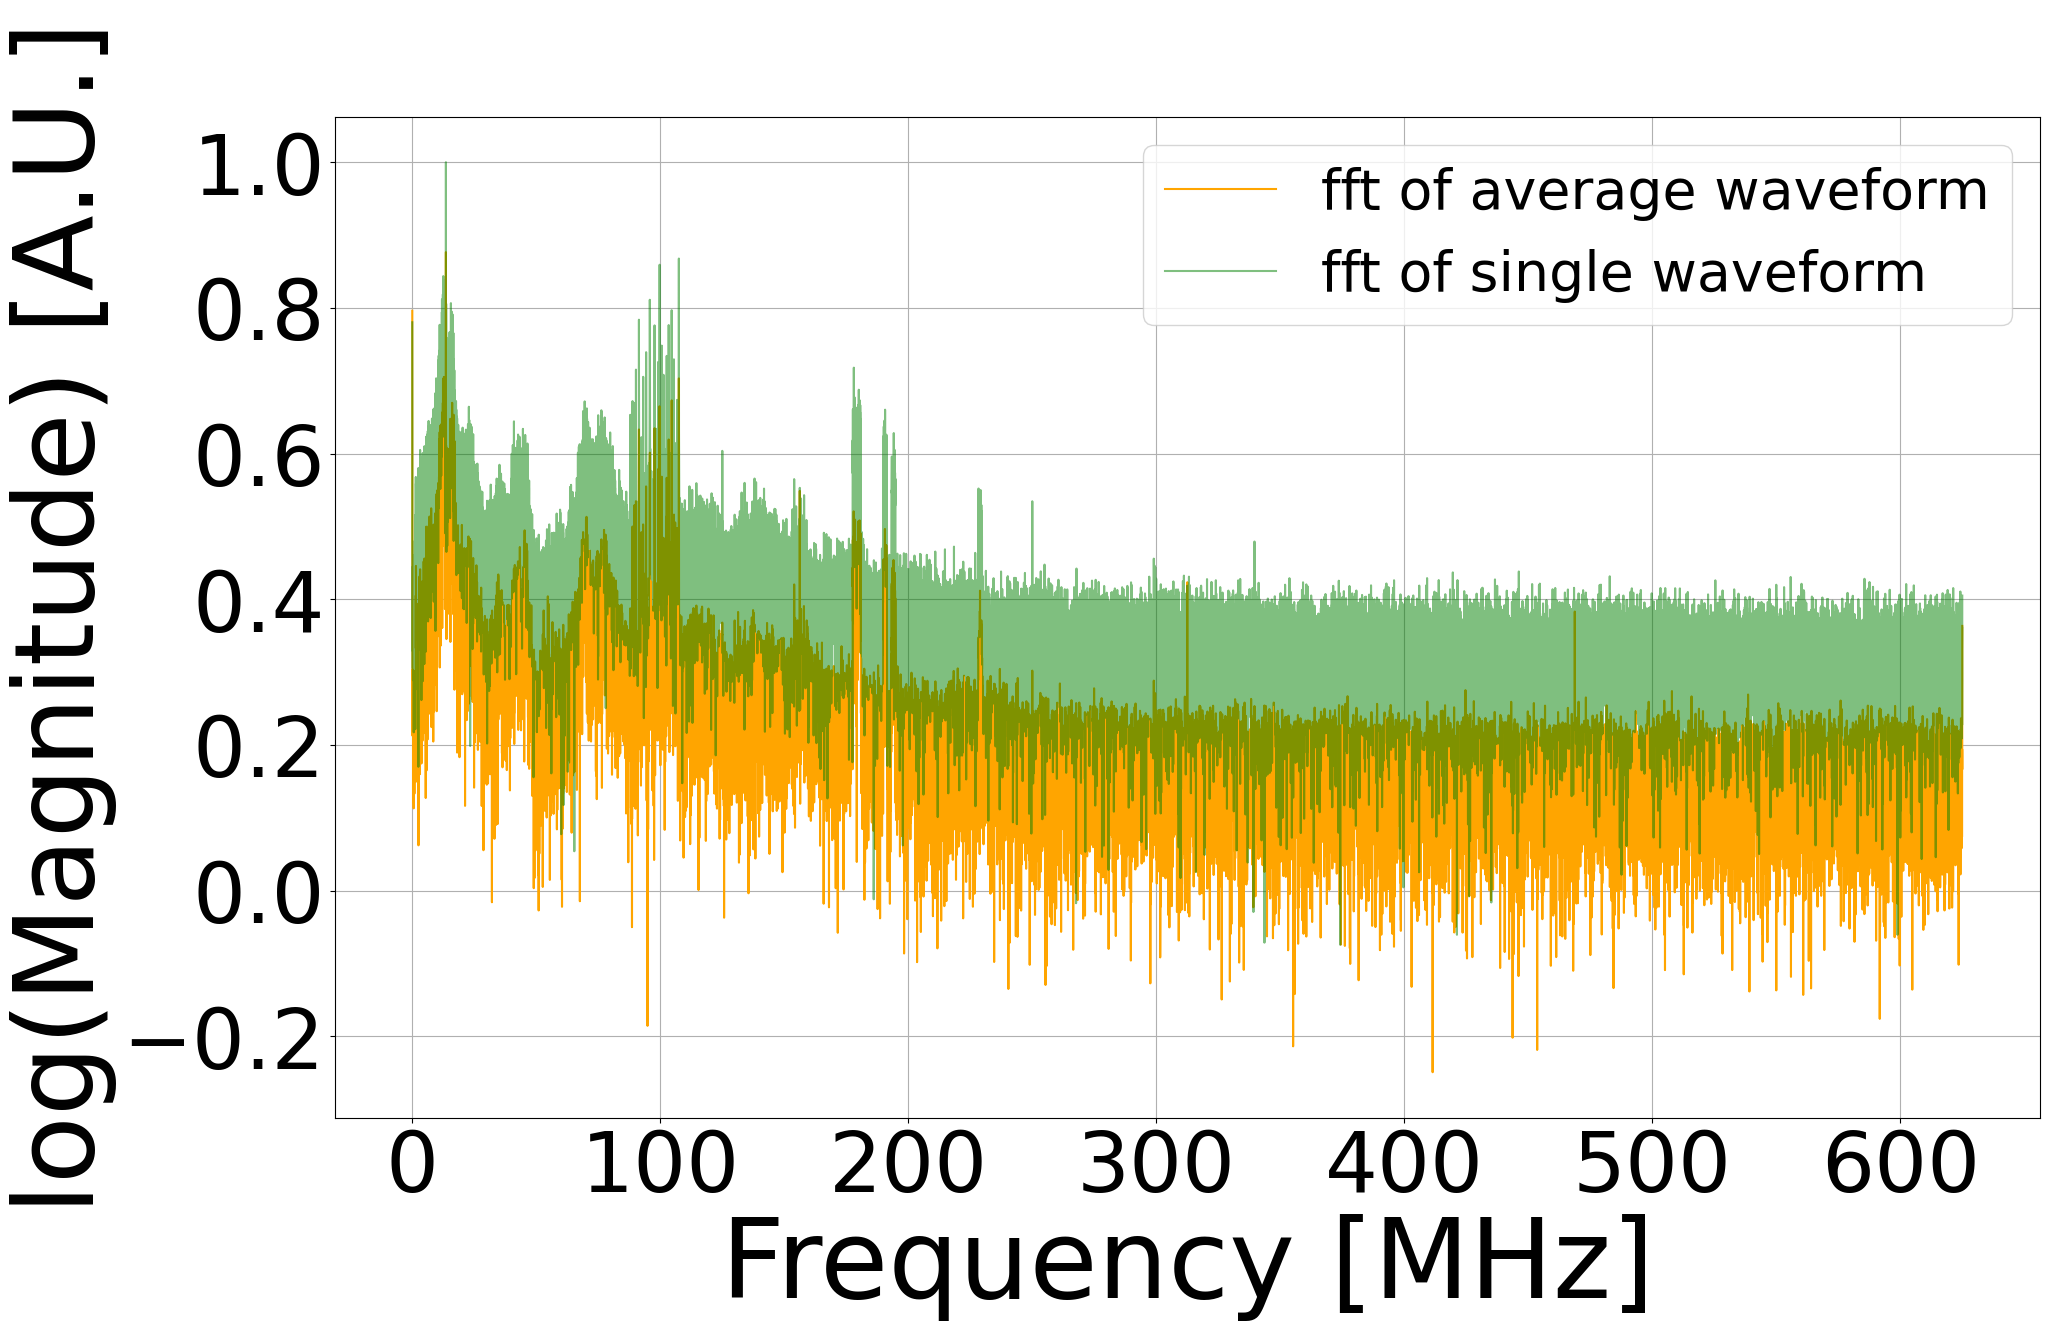

In [79]:
plt.figure(figsize = (22, 13))
plt.plot(freqs_A, (Y_A_log - diff)/max(Y_single_wf_A_log), color = 'orange', label = 'fft of average waveform')
plt.plot(freqs_A, Y_single_wf_A_log/max(Y_single_wf_A_log), alpha = 0.5, color = 'green', label = 'fft of single waveform')

plt.title(' ', fontsize = 80)
plt.xlabel('Frequency [MHz]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.ylabel('log(Magnitude) [A.U.]', fontsize = 80)
plt.yticks(fontsize = 60)
plt.grid(True)
plt.legend(fontsize = 40)

plt.savefig("../Results/080824_15.42/A_method/avg_fft_A.png", format = "png", bbox_inches="tight")
plt.savefig("../Results/080824_15.42/A_method/avg_fft_A.pdf", format = "pdf", bbox_inches="tight")

plt.show()


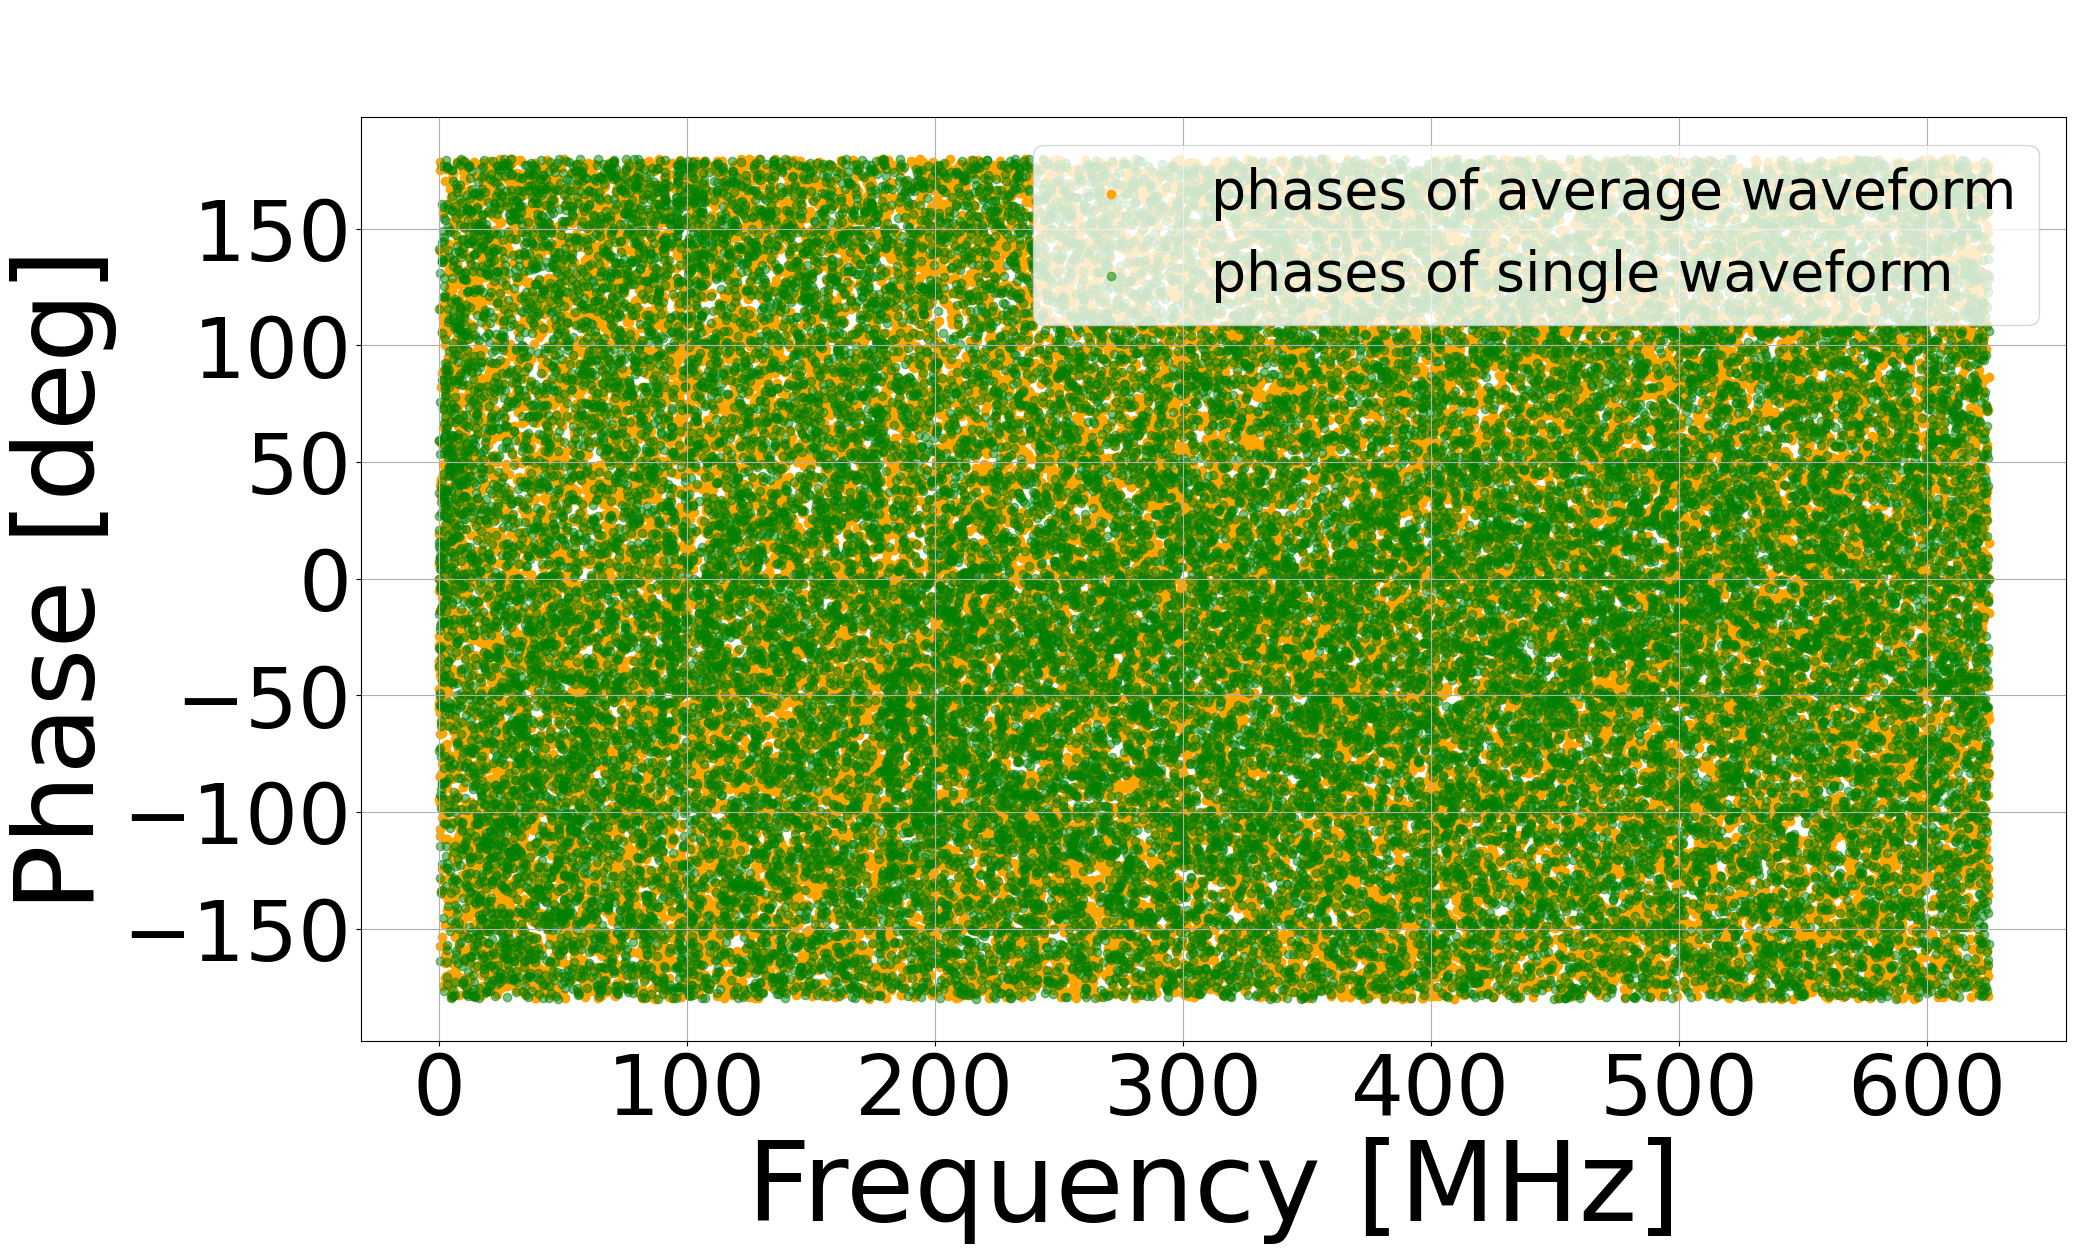

In [69]:
plt.figure(figsize = (22, 12))
plt.scatter(freqs_A, phases_A, color = 'orange', label = 'phases of average waveform')
plt.scatter(freqs_A, phases_single_wf_A,  alpha = 0.5, color = 'green', label = 'phases of single waveform')

plt.title(' ', fontsize = 80)
plt.xlabel('Frequency [MHz]', fontsize = 80)
plt.ylabel('Phase [deg]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.yticks(fontsize = 60)
plt.legend(loc = 'best', fontsize = 40)
plt.grid(True)

plt.savefig("../Results/080824_15.42/A_method/avg_phases_A.png", format = "png", bbox_inches="tight")
plt.savefig("../Results/080824_15.42/A_method/avg_phases_A.pdf", format = "pdf", bbox_inches="tight")

plt.show()

# Method B: Average of the phases of the ffts

In [70]:
file_pattern_wfs = f"../../Waveforms/{day}/{day}_{hour}/{day}_{hour}_wf.csv/{day}_{hour}_wf_*.csv"
file_list_wfs = glob.glob(file_pattern_wfs)

amplitudes_list_B = []

if not file_list:
    print("No files found for the given pattern.")
else:
    for i, file in enumerate(file_list_wfs):
        df = pd.read_csv(file)
        print(df)
        if i == 0:
            times_B = pd.to_numeric(df.iloc[1:, 0], errors = 'coerce').values
        amplitudes_B = pd.to_numeric(df.iloc[1:, 1], errors='coerce').values
        amplitudes_list_B.append(amplitudes_B)
            
all_amplitudes_B = np.stack(amplitudes_list_B, axis = 0)
print(all_amplitudes_B)


              Time    Channel D
0             (us)         (mV)
1       0.00000000  -1.96850400
2       0.00080000  -1.57480300
3       0.00160000  -1.18110200
4       0.00240000  -0.78740150
...            ...          ...
62500  49.99920067   0.00000000
62501  50.00000067   0.39370070
62502  50.00080067  -0.39370070
62503  50.00160067  -1.18110200
62504  50.00240067  -1.18110200

[62505 rows x 2 columns]
              Time    Channel D
0             (us)         (mV)
1       0.00000000   1.57480300
2       0.00080000   0.78740150
3       0.00160000   0.00000000
4       0.00240000   0.00000000
...            ...          ...
62500  49.99920067   1.57480300
62501  50.00000067   0.78740150
62502  50.00080067  -0.39370070
62503  50.00160067  -2.75590500
62504  50.00240067  -4.72440900

[62505 rows x 2 columns]
              Time    Channel D
0             (us)         (mV)
1       0.00000000  -0.39370070
2       0.00080000  -0.39370070
3       0.00160000   0.39370070
4       0.00240000  

### compute the FFTs

In [71]:
Ys_list = []
phases_list = []

for i in range(all_amplitudes_B.shape[0]):
    Y_B, phase_B = rfft(all_amplitudes_B[i, :])
    Ys_list.append(Y_B)
    phases_list.append(phase_B)

Ys_B = np.stack(Ys_list, axis = 0)
phases_B = np.stack(phases_list, axis = 0)

### compute and plot the average fft and the average of their phases

In [72]:
span_B = times_B[len(times_B)-1] 
f_s_avg_fft = len(times_B) / span_B
print(f"f_s_avg_fft = {f_s_avg_fft}")
freqs_B = fft.rfftfreq(all_amplitudes_B.shape[1], 1/f_s_avg_fft) #window lenght, sample spacing

avg_fft_B = np.mean(Ys_B, axis = 0)
avg_phases_B = np.mean(phases_B, axis = 0)
print(f"avg_fft_dBu_B: {avg_fft_B}")
print(f"avg_phases_B: {avg_phases_B}")


f_s_avg_fft = 1250.0199822905822
avg_fft_dBu_B: [8562.75769291  119.37760201   96.86667995 ...   46.67938116   44.17882861
   60.8882722 ]
avg_phases_B: [  0.          12.04390863  -2.41214908 ...   0.02600033 -11.75326485
  16.875     ]


In [73]:
Y_B_log = np.log(Y_B)
avg_fft_B_log = np.log(avg_fft_B)

offset_blue = np.mean(Y_B_log[(freqs_B >= 250) & (freqs_B <= 350)])
offset_orange = np.mean(avg_fft_B_log[(freqs_B >= 250) & (freqs_B <= 350)])
print(f"offset blue: {offset_blue} - offset orange: {offset_orange} = {offset_blue - offset_orange}")
diff = offset_blue - offset_orange

offset blue: 3.771119922596193 - offset orange: 3.9295246867096676 = -0.1584047641134747


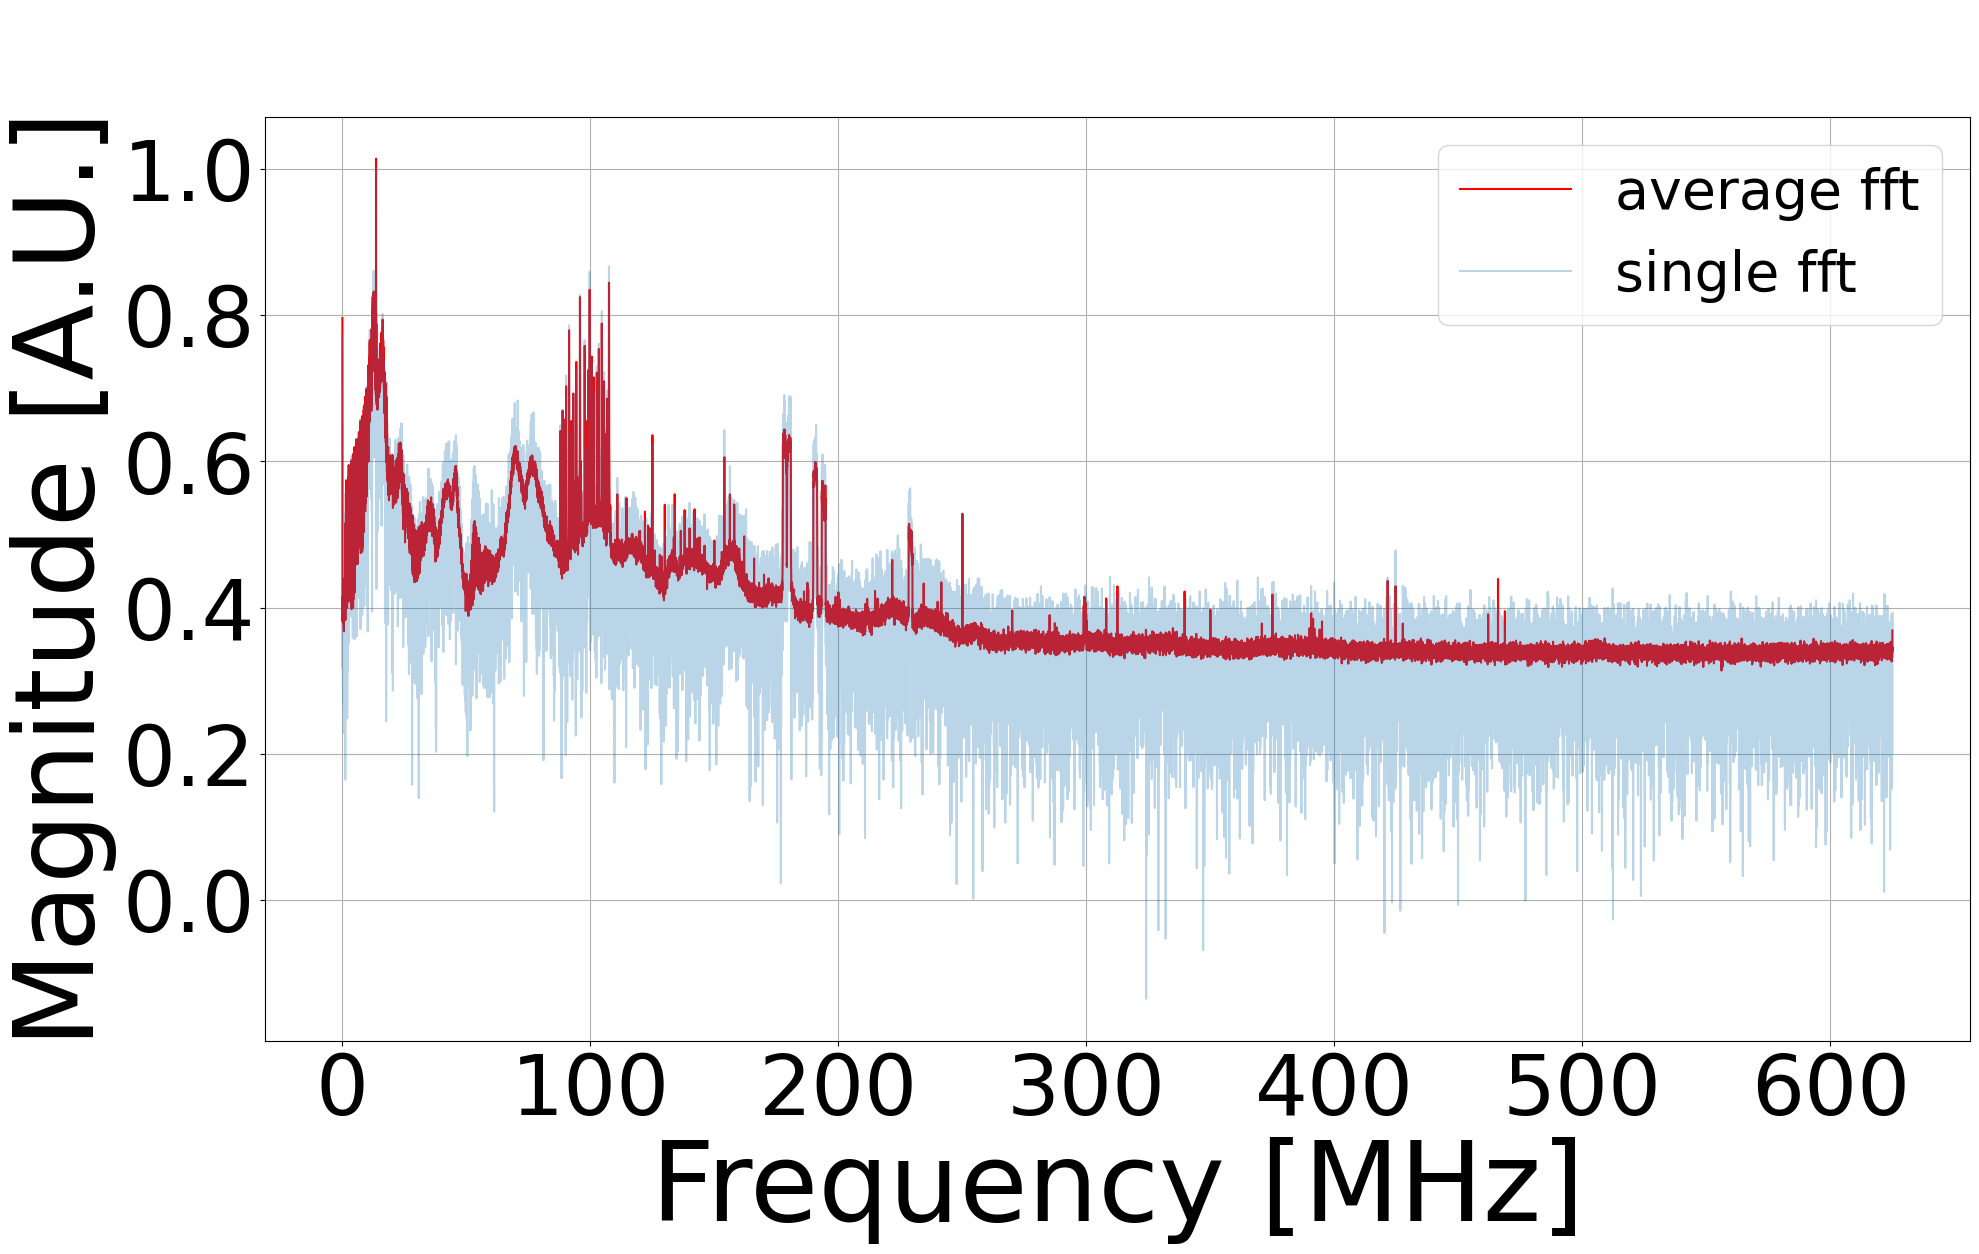

In [80]:
plt.figure(figsize=(22, 12))
plt.plot(freqs_B, (avg_fft_B_log - diff)/max(Y_B_log), color = 'red', label = 'average fft')
plt.plot(freqs_B, Y_B_log/max(Y_B_log), alpha = 0.3, label = 'single fft')

plt.title(' ', fontsize = 80)
plt.xlabel('Frequency [MHz]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.ylabel('Magnitude [A.U.]', fontsize = 80)
plt.yticks(fontsize = 60)
plt.grid(True)
plt.legend(fontsize = 40)


plt.savefig("../Results/080824_15.42/B_method/avg_fft_B.png", format = "png", bbox_inches="tight")
plt.savefig("../Results/080824_15.42/B_method/avg_fft_B.pdf", format = "pdf", bbox_inches="tight")

plt.show()


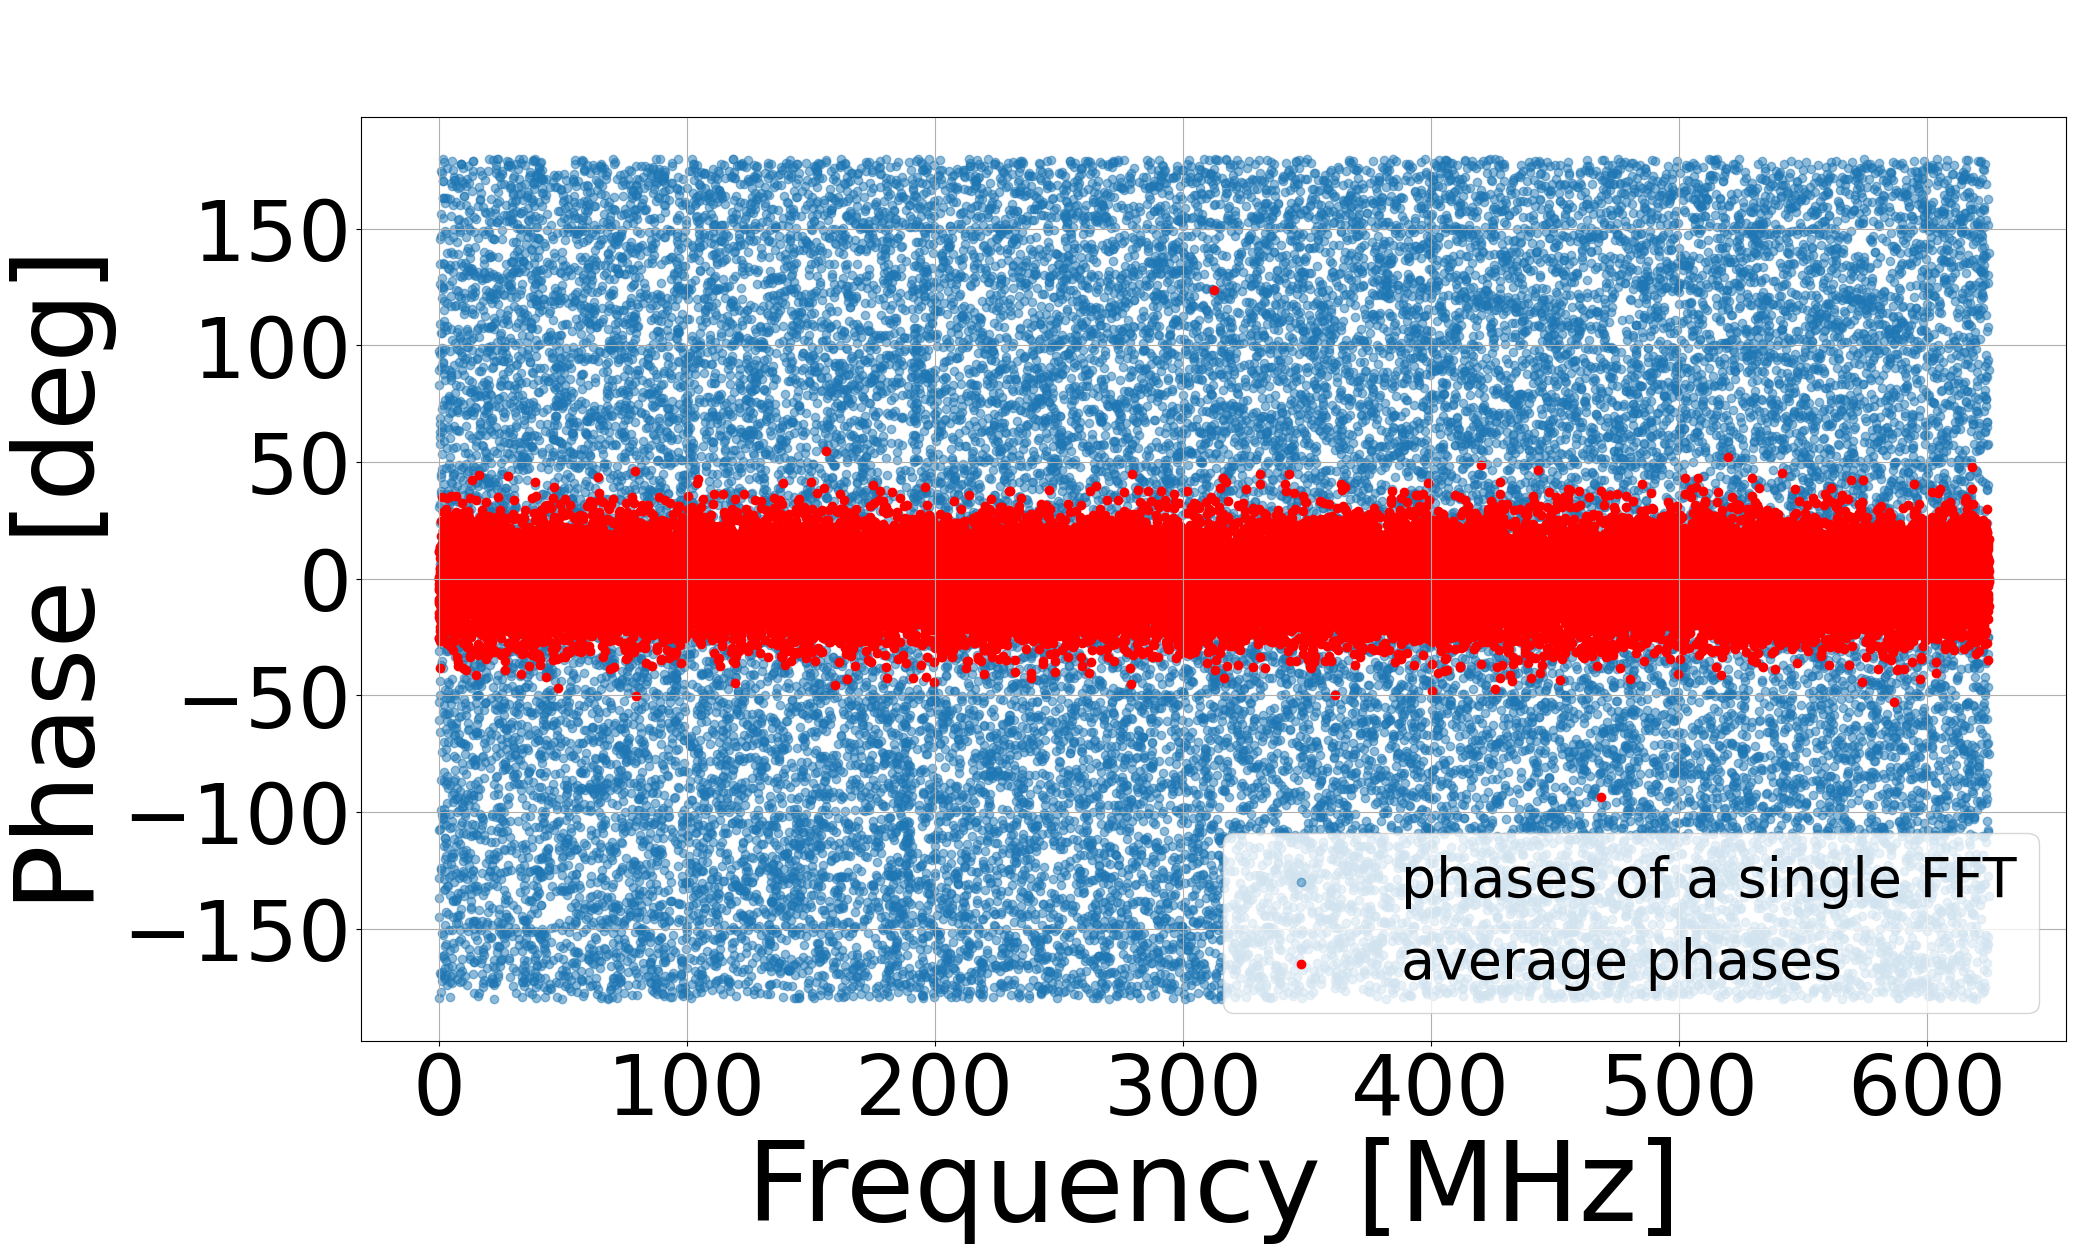

In [75]:
plt.figure(figsize=(22, 12))
#plt.errorbar(freqs_B, phases_avg, yerr = phases_err_avg, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.scatter(freqs_B, phase_B, alpha = 0.5, label = 'phases of a single FFT')
plt.scatter(freqs_B, avg_phases_B, color = 'red', label = 'average phases')

plt.title(' ', fontsize = 80)
plt.xlabel('Frequency [MHz]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.ylabel('Phase [deg]', fontsize = 80)
plt.yticks(fontsize = 60)
plt.grid(True)
plt.legend(fontsize = 40, loc = 'best')

plt.savefig("../Results/080824_15.42/B_method/avg_phases_B.png", format = "png", bbox_inches="tight")
plt.savefig("../Results/080824_15.42/B_method/avg_phases_B.pdf", format = "pdf", bbox_inches="tight")

plt.show()


# Comparison between the two methods

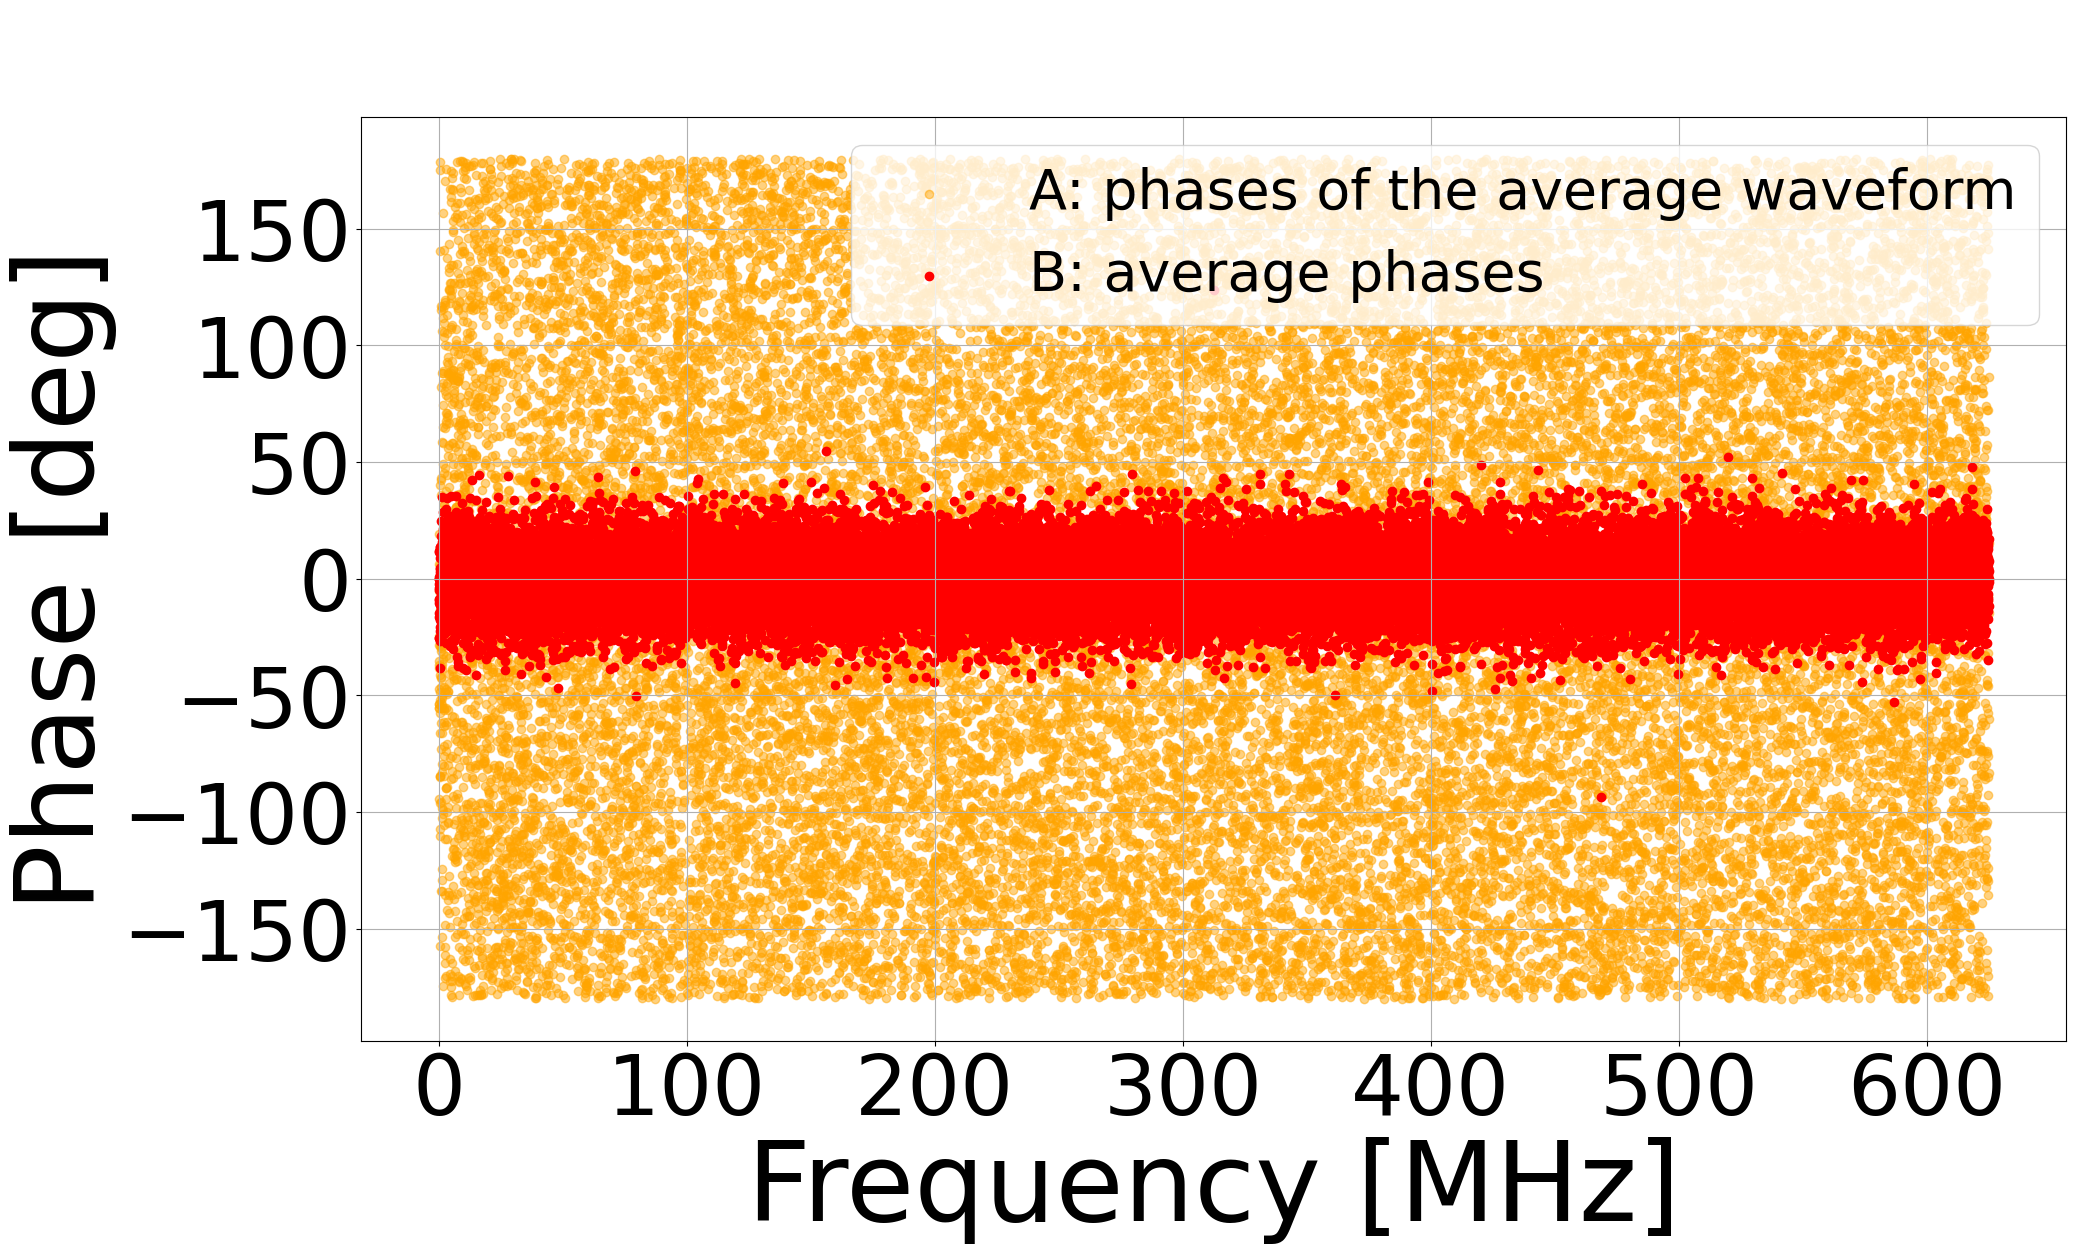

In [76]:
plt.figure(figsize=(22, 12))

plt.scatter(freqs_A, phases_A, alpha = 0.5, color = 'orange', label = 'A: phases of the average waveform')
plt.title(' ', fontsize = 80)
plt.xlabel('Frequency [MHz]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.ylabel('Phase [deg]', fontsize = 80)
plt.yticks(fontsize = 60)
plt.grid(True)

#---------------------------------------------------------------
plt.scatter(freqs_B, avg_phases_B, color = 'red', label = 'B: average phases')

plt.legend(fontsize = 40, loc = 'best')
plt.savefig("../Results/080824_15.42/A_vs_B_phases.png", format = "png", bbox_inches="tight")
plt.savefig("../Results/080824_15.42/A_vs_B_phases.pdf", format = "pdf", bbox_inches="tight")

plt.show()